In [70]:
img1 = cv2.imread('atash2.jpg',0)
img2 = cv2.imread('zaid.jpeg',0)
img3 =  cv2.imread('cnic_more_easy.jpeg',0)
img4 = cv2.imread('base_cnic.png',0)
img1_to_hsv = cv2.cvtColor(cv2.imread('atash2.jpg'), cv2.COLOR_BGR2HSV)
img2_to_hsv = cv2.cvtColor(cv2.imread('zaid.jpeg'), cv2.COLOR_BGR2HSV)
img3_to_hsv = cv2.cvtColor(cv2.imread('cnic_more_easy.jpeg'), cv2.COLOR_BGR2HSV)
img4_to_hsv = cv2.cvtColor(cv2.imread('base_cnic.png'), cv2.COLOR_BGR2HSV)
img = [img1,img2,img3,img4]
img_to_hsv = [img1_to_hsv,img2_to_hsv,img3_to_hsv,img4_to_hsv]

In [71]:
import os
import cv2
import numpy as np
from matplotlib.image import imread
import matplotlib.pyplot as plt
import skimage
from skimage import img_as_ubyte
from skimage.color import rgb2gray
from skimage.color import gray2rgb
from skimage.filters import try_all_threshold
from skimage import filters

# Apply the Component analysis function

def ccfinder(img):
    # Find the connected components
    connectivity = 8
    output = cv2.connectedComponentsWithStats(img, connectivity, cv2.CV_32S)
    # Get the results
    # The first cell is the number of labels
    num_labels = output[0]
    # The second cell is the label matrix
    labels = output[1]
    # The third cell is the stat matrix
    stats = output[2]
    # The fourth cell is the centroid matrix
    centroids = output[3]
    return num_labels, labels, stats, centroids

def getEdges(img):
    horizontalEdges = np.array([[-1,0,-1],[0,0,0],[1,0,1]])
    verticalEdges = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
    horizontalEdgescards = np.zeros(img.shape)
    verticalEdgescards = np.zeros(img.shape)
    for i in range(1, img.shape[0]-1):
        for j in range(1, img.shape[1]-1):
            horizontalEdgescards[i,j] = np.sum(img[i-1:i+2, j-1:j+2]*horizontalEdges)
            verticalEdgescards[i,j] = np.sum(img[i-1:i+2, j-1:j+2]*verticalEdges)

    edges = verticalEdgescards + horizontalEdgescards
    return edges

In [72]:
import numpy as np
import scipy as sp
import scipy.ndimage
import cv2
import matplotlib.pyplot as plt
import imageio

def box(img, r):
    """ O(1) box filter
        img - >= 2d image
        r   - radius of box filter
    """
    (rows, cols) = img.shape[:2]
    imDst = np.zeros_like(img)


    tile = [1] * img.ndim
    tile[0] = r
    imCum = np.cumsum(img, 0)
    imDst[0:r+1, :, ...] = imCum[r:2*r+1, :, ...]
    imDst[r+1:rows-r, :, ...] = imCum[2*r+1:rows, :, ...] - imCum[0:rows-2*r-1, :, ...]
    imDst[rows-r:rows, :, ...] = np.tile(imCum[rows-1:rows, :, ...], tile) - imCum[rows-2*r-1:rows-r-1, :, ...]

    tile = [1] * img.ndim
    tile[1] = r
    imCum = np.cumsum(imDst, 1)
    imDst[:, 0:r+1, ...] = imCum[:, r:2*r+1, ...]
    imDst[:, r+1:cols-r, ...] = imCum[:, 2*r+1 : cols, ...] - imCum[:, 0 : cols-2*r-1, ...]
    imDst[:, cols-r: cols, ...] = np.tile(imCum[:, cols-1:cols, ...], tile) - imCum[:, cols-2*r-1 : cols-r-1, ...]

    return imDst

def _gf_color(I, p, r, eps, s=None):
    """ Color guided filter
    I - guide image (rgb)
    p - filtering input (single channel)
    r - window radius
    eps - regularization (roughly, variance of non-edge noise)
    s - subsampling factor for fast guided filter
    """
    fullI = I
    fullP = p
    if s is not None:
        I = sp.ndimage.zoom(fullI, [1/s, 1/s, 1], order=1)
        p = sp.ndimage.zoom(fullP, [1/s, 1/s], order=1)
        r = round(r / s)

    h, w = p.shape[:2]
    N = box(np.ones((h, w)), r)

    mI_r = box(I[:,:,0], r) / N
    mI_g = box(I[:,:,1], r) / N
    mI_b = box(I[:,:,2], r) / N

    mP = box(p, r) / N

    # mean of I * p
    mIp_r = box(I[:,:,0]*p, r) / N
    mIp_g = box(I[:,:,1]*p, r) / N
    mIp_b = box(I[:,:,2]*p, r) / N

    # per-patch covariance of (I, p)
    covIp_r = mIp_r - mI_r * mP
    covIp_g = mIp_g - mI_g * mP
    covIp_b = mIp_b - mI_b * mP

    # symmetric covariance matrix of I in each patch:
    #       rr rg rb
    #       rg gg gb
    #       rb gb bb
    var_I_rr = box(I[:,:,0] * I[:,:,0], r) / N - mI_r * mI_r;
    var_I_rg = box(I[:,:,0] * I[:,:,1], r) / N - mI_r * mI_g;
    var_I_rb = box(I[:,:,0] * I[:,:,2], r) / N - mI_r * mI_b;

    var_I_gg = box(I[:,:,1] * I[:,:,1], r) / N - mI_g * mI_g;
    var_I_gb = box(I[:,:,1] * I[:,:,2], r) / N - mI_g * mI_b;

    var_I_bb = box(I[:,:,2] * I[:,:,2], r) / N - mI_b * mI_b;

    a = np.zeros((h, w, 3))
    for i in range(h):
        for j in range(w):
            sig = np.array([
                [var_I_rr[i,j], var_I_rg[i,j], var_I_rb[i,j]],
                [var_I_rg[i,j], var_I_gg[i,j], var_I_gb[i,j]],
                [var_I_rb[i,j], var_I_gb[i,j], var_I_bb[i,j]]
            ])
            covIp = np.array([covIp_r[i,j], covIp_g[i,j], covIp_b[i,j]])
            a[i,j,:] = np.linalg.solve(sig + eps * np.eye(3), covIp)

    b = mP - a[:,:,0] * mI_r - a[:,:,1] * mI_g - a[:,:,2] * mI_b

    meanA = box(a, r) / N[...,np.newaxis]
    meanB = box(b, r) / N

    if s is not None:
        meanA = sp.ndimage.zoom(meanA, [s, s, 1], order=1)
        meanB = sp.ndimage.zoom(meanB, [s, s], order=1)

    q = np.sum(meanA * fullI, axis=2) + meanB

    return q


def _gf_gray(I, p, r, eps, s=None):
    """ grayscale (fast) guided filter
        I - guide image (1 channel)
        p - filter input (1 channel)
        r - window raidus
        eps - regularization (roughly, allowable variance of non-edge noise)
        s - subsampling factor for fast guided filter
    """
    if s is not None:
        Isub = sp.ndimage.zoom(I, 1/s, order=1)
        Psub = sp.ndimage.zoom(p, 1/s, order=1)
        r = round(r / s)
    else:
        Isub = I
        Psub = p


    (rows, cols) = Isub.shape

    N = box(np.ones([rows, cols]), r)

    meanI = box(Isub, r) / N
    meanP = box(Psub, r) / N
    corrI = box(Isub * Isub, r) / N
    corrIp = box(Isub * Psub, r) / N
    varI = corrI - meanI * meanI
    covIp = corrIp - meanI * meanP


    a = covIp / (varI + eps)
    b = meanP - a * meanI

    meanA = box(a, r) / N
    meanB = box(b, r) / N

    if s is not None:
        meanA = sp.ndimage.zoom(meanA, s, order=1)
        meanB = sp.ndimage.zoom(meanB, s, order=1)

    q = meanA * I + meanB
    return q


def _gf_colorgray(I, p, r, eps, s=None):
    """ automatically choose color or gray guided filter based on I's shape """
    if I.ndim == 2 or I.shape[2] == 1:
        return _gf_gray(I, p, r, eps, s)
    elif I.ndim == 3 and I.shape[2] == 3:
        return _gf_color(I, p, r, eps, s)
    else:
        print("Invalid guide dimensions:", I.shape)


def guided_filter(I, p, r, eps, s=None):
    """ run a guided filter per-channel on filtering input p
        I - guide image (1 or 3 channel)
        p - filter input (n channel)
        r - window raidus
        eps - regularization (roughly, allowable variance of non-edge noise)
        s - subsampling factor for fast guided filter
    """
    if p.ndim == 2:
        p3 = p[:,:,np.newaxis]

    out = np.zeros_like(p3)
    for ch in range(p3.shape[2]):
        out[:,:,ch] = _gf_colorgray(I, p3[:,:,ch], r, eps, s)
    return np.squeeze(out) if p.ndim == 2 else out


def test_gf(image,eps):
    ''' The image passed should be single channel i.e greyscale and of good quality
        eps to be 0.01 or 0.05
        r to be 8
    '''
    card = image.astype(np.float32) / 255
    r = 8
    card_smoothed = _gf_gray(card, card, r, eps)
    return card_smoothed

Text(0.5, 1.0, 'ADPT THRESH')

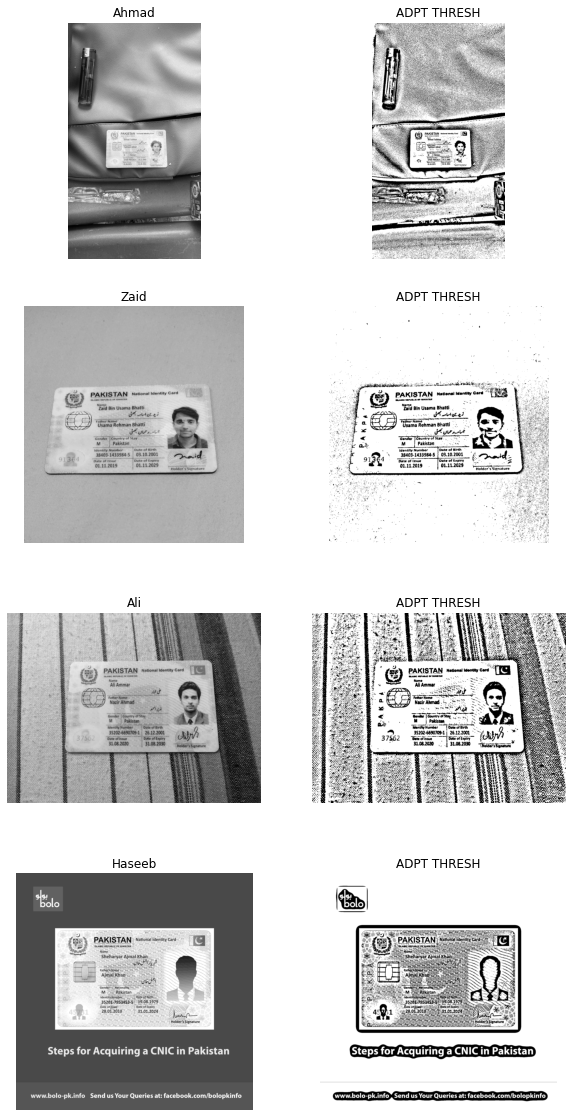

In [73]:
# adaptive thresholding
adp_th1 = cv2.adaptiveThreshold(img1,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)
adp_th2 = cv2.adaptiveThreshold(img2,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)
adp_th3 = cv2.adaptiveThreshold(img3,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)
adp_th4 = cv2.adaptiveThreshold(img4,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)


fig = plt.figure(figsize=(10, 20))
# setting values to rows and column variables
rows = 4
columns = 2
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(img1,'gray')
plt.axis('off')
plt.title("Ahmad")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(adp_th1,'gray')
plt.axis('off')
plt.title("ADPT THRESH")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(img2,'gray')
plt.axis('off')
plt.title("Zaid")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(adp_th2,'gray')
plt.axis('off')
plt.title("ADPT THRESH")

# Adds a subplot at the 5th position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(img3,'gray')
plt.axis('off')
plt.title("Ali")
  
# Adds a subplot at the 6th position
fig.add_subplot(rows, columns, 6)
  
# showing image
plt.imshow(adp_th3,'gray')
plt.axis('off')
plt.title("ADPT THRESH")

# Adds a subplot at the 7th position
fig.add_subplot(rows, columns, 7)
  
# showing image
plt.imshow(img4,'gray')
plt.axis('off')
plt.title("Haseeb")
  
# Adds a subplot at the 8th position
fig.add_subplot(rows, columns, 8)
  
# showing image
plt.imshow(adp_th4,'gray')
plt.axis('off')
plt.title("ADPT THRESH")

Text(0.5, 1.0, 'ADPT THRESH & Bilateral')

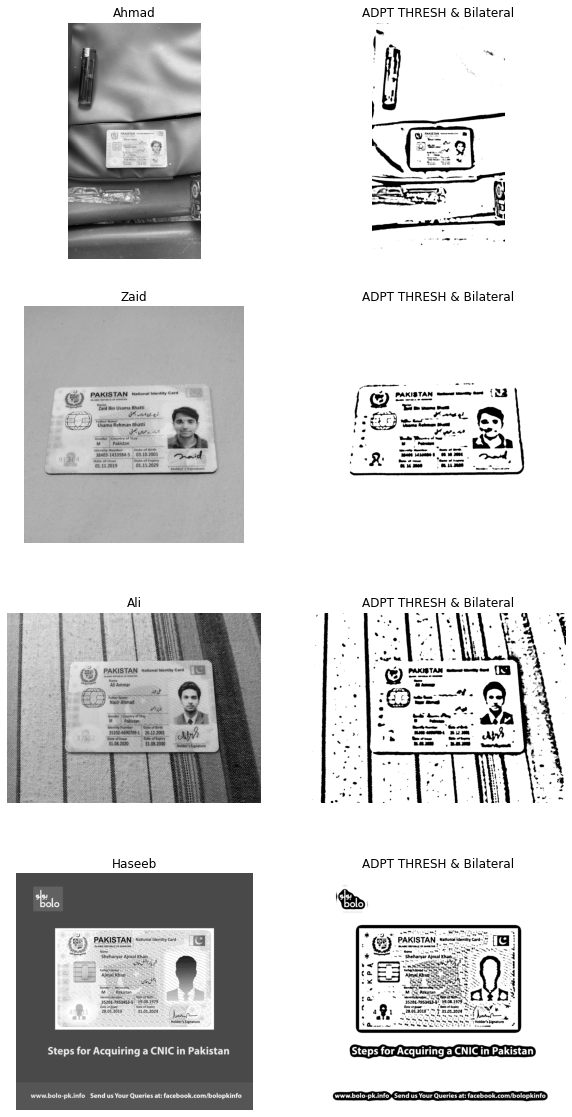

In [74]:
bilateral1 = cv2.bilateralFilter(img1, 15, 75, 75)
bilateral2 = cv2.bilateralFilter(img2, 15, 75, 75)
bilateral3 = cv2.bilateralFilter(img3, 15, 75, 75)
bilateral4 = cv2.bilateralFilter(img4, 15, 75, 75)
# adaptive thresholding
adp_th1_bl = cv2.adaptiveThreshold(bilateral1,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)
adp_th2_bl = cv2.adaptiveThreshold(bilateral2,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)
adp_th3_bl = cv2.adaptiveThreshold(bilateral3,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)
adp_th4_bl = cv2.adaptiveThreshold(bilateral4,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)

adp_th_bl = [adp_th1_bl,adp_th2_bl,adp_th3_bl,adp_th4_bl,]

fig = plt.figure(figsize=(10, 20))
# setting values to rows and column variables
rows = 4
columns = 2
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(img1,'gray')
plt.axis('off')
plt.title("Ahmad")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(adp_th1_bl,'gray')
plt.axis('off')
plt.title("ADPT THRESH & Bilateral")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(img2,'gray')
plt.axis('off')
plt.title("Zaid")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(adp_th2_bl,'gray')
plt.axis('off')
plt.title("ADPT THRESH & Bilateral")

# Adds a subplot at the 5th position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(img3,'gray')
plt.axis('off')
plt.title("Ali")
  
# Adds a subplot at the 6th position
fig.add_subplot(rows, columns, 6)
  
# showing image
plt.imshow(adp_th3_bl,'gray')
plt.axis('off')
plt.title("ADPT THRESH & Bilateral")

# Adds a subplot at the 7th position
fig.add_subplot(rows, columns, 7)
  
# showing image
plt.imshow(img4,'gray')
plt.axis('off')
plt.title("Haseeb")
  
# Adds a subplot at the 8th position
fig.add_subplot(rows, columns, 8)
  
# showing image
plt.imshow(adp_th4_bl,'gray')
plt.axis('off')
plt.title("ADPT THRESH & Bilateral")

In [75]:
#eps = 0.010
guided1 = img_as_ubyte(test_gf(img1,0.010))
guided2 = img_as_ubyte(test_gf(img2,0.010))
guided3 = img_as_ubyte(test_gf(img3,0.010))
guided4 = img_as_ubyte(test_gf(img4,0.010))

#eps = 0.025
guided5 = img_as_ubyte(test_gf(img1,0.025))
guided6 = img_as_ubyte(test_gf(img2,0.025))
guided7 = img_as_ubyte(test_gf(img3,0.025))
guided8 = img_as_ubyte(test_gf(img4,0.025))

#eps = 0.050
guided9 = img_as_ubyte(test_gf(img1,0.050))
guided10 = img_as_ubyte(test_gf(img2,0.050))
guided11 = img_as_ubyte(test_gf(img3,0.050))
guided12 = img_as_ubyte(test_gf(img4,0.050))

# adaptive thresholding
adp_th1_gf = cv2.adaptiveThreshold(guided1,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)
adp_th2_gf = cv2.adaptiveThreshold(guided2,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)
adp_th3_gf = cv2.adaptiveThreshold(guided3,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)
adp_th4_gf = cv2.adaptiveThreshold(guided4,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)
adp_th5_gf = cv2.adaptiveThreshold(guided5,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)
adp_th6_gf = cv2.adaptiveThreshold(guided6,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)
adp_th7_gf = cv2.adaptiveThreshold(guided7,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)
adp_th8_gf = cv2.adaptiveThreshold(guided8,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)
adp_th9_gf = cv2.adaptiveThreshold(guided9,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)
adp_th10_gf = cv2.adaptiveThreshold(guided10,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)
adp_th11_gf = cv2.adaptiveThreshold(guided11,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)
adp_th12_gf = cv2.adaptiveThreshold(guided12,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,107,9)


fig = plt.figure(figsize=(20, 30))
# setting values to rows and column variables
rows = 4
columns = 4
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(img1,'gray')
plt.axis('off')
plt.title("Ahmad")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(adp_th1_gf,'gray')
plt.axis('off')
plt.title("ADPT THRESH & Guided 0.010")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(adp_th5_gf,'gray')
plt.axis('off')
plt.title("ADPT THRESH & Guided 0.025")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(adp_th9_gf,'gray')
plt.axis('off')
plt.title("ADPT THRESH & Guided 0.050")

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(img2,'gray')
plt.axis('off')
plt.title("Zaid")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 6)
  
# showing image
plt.imshow(adp_th2_gf,'gray')
plt.axis('off')
plt.title("ADPT THRESH & Guided 0.010")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 7)
  
# showing image
plt.imshow(adp_th6_gf,'gray')
plt.axis('off')
plt.title("ADPT THRESH & Guided 0.025")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 8)
  
# showing image
plt.imshow(adp_th10_gf,'gray')
plt.axis('off')
plt.title("ADPT THRESH & Guided 0.050")

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 9)
  
# showing image
plt.imshow(img3,'gray')
plt.axis('off')
plt.title("Ali")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 10)
  
# showing image
plt.imshow(adp_th3_gf,'gray')
plt.axis('off')
plt.title("ADPT THRESH & Guided 0.010")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 11)
  
# showing image
plt.imshow(adp_th7_gf,'gray')
plt.axis('off')
plt.title("ADPT THRESH & Guided 0.025")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 12)
  
# showing image
plt.imshow(adp_th11_gf,'gray')
plt.axis('off')
plt.title("ADPT THRESH & Guided 0.050")

# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 13)
  
# showing image
plt.imshow(img4,'gray')
plt.axis('off')
plt.title("Haseeb")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 14)
  
# showing image
plt.imshow(adp_th4_gf,'gray')
plt.axis('off')
plt.title("ADPT THRESH & Guided 0.010")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 15)
  
# showing image
plt.imshow(adp_th8_gf,'gray')
plt.axis('off')
plt.title("ADPT THRESH & Guided 0.025")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 16)
  
# showing image
plt.imshow(adp_th12_gf,'gray')
plt.axis('off')
plt.title("ADPT THRESH & Guided 0.050")


ValueError: Images of type float must be between -1 and 1.

Text(0.5, 1.0, 'OTSU THRESH & GB')

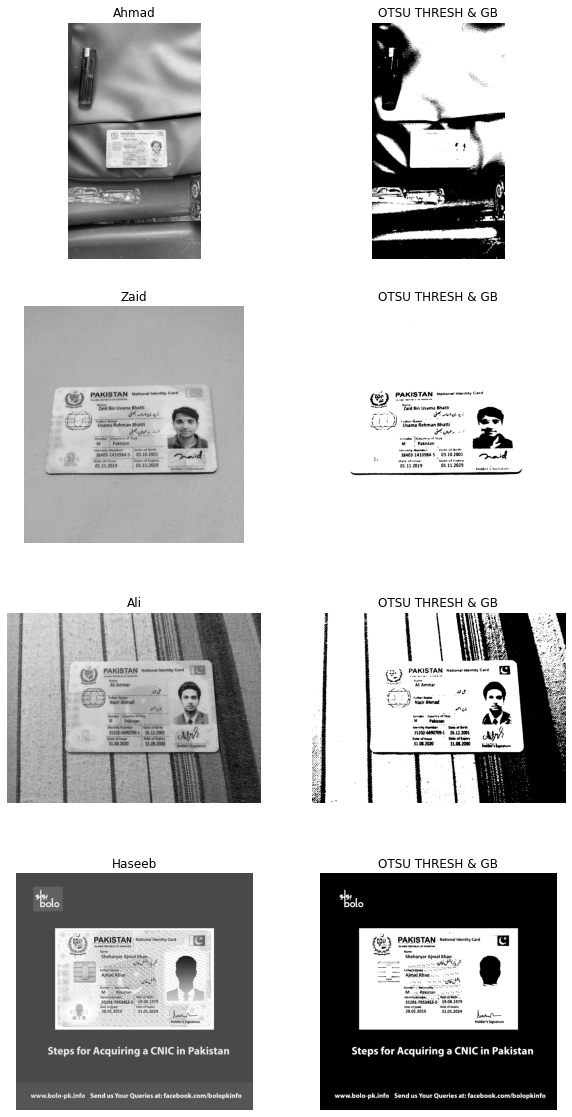

In [76]:
# Otsu's thresholding with Gaussian Blur
blur1 = cv2.GaussianBlur(img1,(5,5),0)
ret1,gb_th1 = cv2.threshold(blur1,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
blur2 = cv2.GaussianBlur(img2,(5,5),0)
ret2,gb_th2= cv2.threshold(blur2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
blur3 = cv2.GaussianBlur(img3,(5,5),0)
ret3,gb_th3 = cv2.threshold(blur3,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
blur4 = cv2.GaussianBlur(img4,(5,5),0)
ret4,gb_th4 = cv2.threshold(blur4,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)


fig = plt.figure(figsize=(10, 20))
# setting values to rows and column variables
rows = 4
columns = 2
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(img1,'gray')
plt.axis('off')
plt.title("Ahmad")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(gb_th1,'gray')
plt.axis('off')
plt.title("OTSU THRESH & GB")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(img2,'gray')
plt.axis('off')
plt.title("Zaid")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(gb_th2,'gray')
plt.axis('off')
plt.title("OTSU THRESH & GB")

# Adds a subplot at the 5th position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(img3,'gray')
plt.axis('off')
plt.title("Ali")
  
# Adds a subplot at the 6th position
fig.add_subplot(rows, columns, 6)
  
# showing image
plt.imshow(gb_th3,'gray')
plt.axis('off')
plt.title("OTSU THRESH & GB")

# Adds a subplot at the 7th position
fig.add_subplot(rows, columns, 7)
  
# showing image
plt.imshow(img4,'gray')
plt.axis('off')
plt.title("Haseeb")
  
# Adds a subplot at the 8th position
fig.add_subplot(rows, columns, 8)
  
# showing image
plt.imshow(gb_th4,'gray')
plt.axis('off')
plt.title("OTSU THRESH & GB")

Text(0.5, 1.0, 'OTSU THRESH')

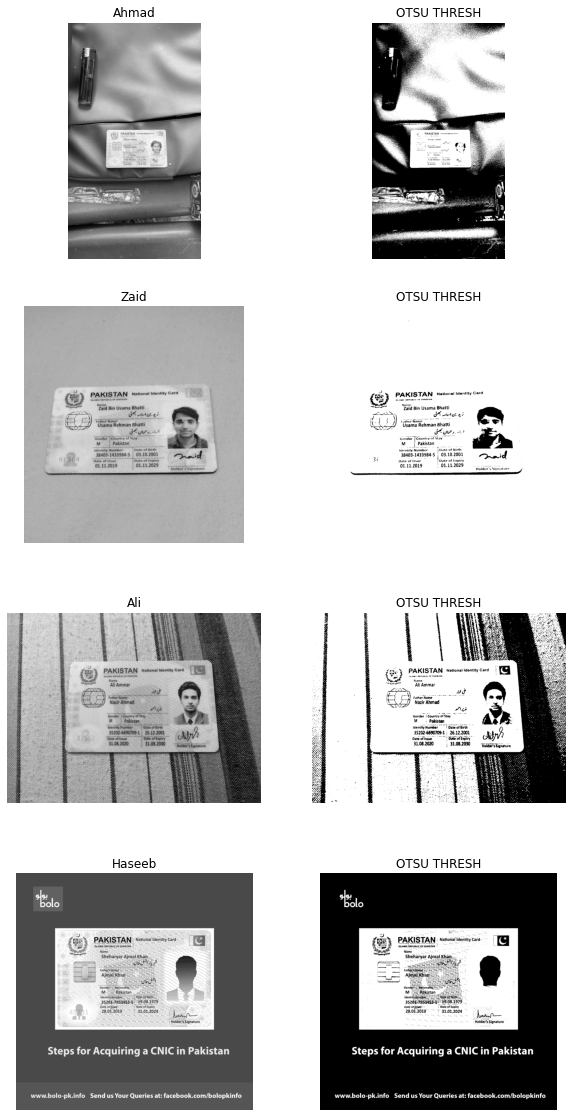

In [77]:
# Otsu's thresholding
ret1,otsu_th1 = cv2.threshold(img1,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret2,otsu_th2 = cv2.threshold(img2,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret3,otsu_th3 = cv2.threshold(img3,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
ret4,otsu_th4 = cv2.threshold(img4,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)


fig = plt.figure(figsize=(10, 20))
# setting values to rows and column variables
rows = 4
columns = 2
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(img1,'gray')
plt.axis('off')
plt.title("Ahmad")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(otsu_th1,'gray')
plt.axis('off')
plt.title("OTSU THRESH")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(img2,'gray')
plt.axis('off')
plt.title("Zaid")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(otsu_th2,'gray')
plt.axis('off')
plt.title("OTSU THRESH")

# Adds a subplot at the 5th position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(img3,'gray')
plt.axis('off')
plt.title("Ali")
  
# Adds a subplot at the 6th position
fig.add_subplot(rows, columns, 6)
  
# showing image
plt.imshow(otsu_th3,'gray')
plt.axis('off')
plt.title("OTSU THRESH")

# Adds a subplot at the 7th position
fig.add_subplot(rows, columns, 7)
  
# showing image
plt.imshow(img4,'gray')
plt.axis('off')
plt.title("Haseeb")
  
# Adds a subplot at the 8th position
fig.add_subplot(rows, columns, 8)
  
# showing image
plt.imshow(otsu_th4,'gray')
plt.axis('off')
plt.title("OTSU THRESH")

Text(0.5, 1.0, 'Green HSV mask')

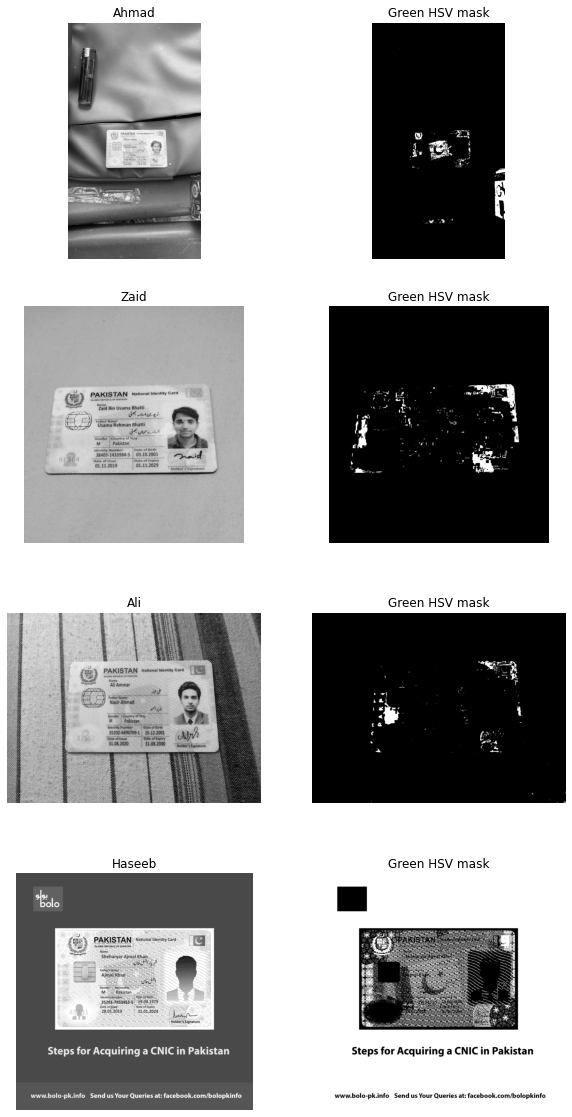

In [78]:
green_lower = np.array([36, 25, 25], np.uint8)
green_upper = np.array([86, 255, 255], np.uint8)

green_im1 = cv2.inRange(img1_to_hsv, green_lower, green_upper)
green_im2 = cv2.inRange(img2_to_hsv, green_lower, green_upper)
green_im3 = cv2.inRange(img3_to_hsv, green_lower, green_upper)
green_im4 = cv2.inRange(img4_to_hsv, green_lower, green_upper)

fig = plt.figure(figsize=(10, 20))
# setting values to rows and column variables
rows = 4
columns = 2
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(img1,'gray')
plt.axis('off')
plt.title("Ahmad")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(green_im1,'gray')
plt.axis('off')
plt.title("Green HSV mask")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(img2,'gray')
plt.axis('off')
plt.title("Zaid")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(green_im2,'gray')
plt.axis('off')
plt.title("Green HSV mask")

# Adds a subplot at the 5th position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(img3,'gray')
plt.axis('off')
plt.title("Ali")
  
# Adds a subplot at the 6th position
fig.add_subplot(rows, columns, 6)
  
# showing image
plt.imshow(green_im3,'gray')
plt.axis('off')
plt.title("Green HSV mask")

# Adds a subplot at the 7th position
fig.add_subplot(rows, columns, 7)
  
# showing image
plt.imshow(img4,'gray')
plt.axis('off')
plt.title("Haseeb")
  
# Adds a subplot at the 8th position
fig.add_subplot(rows, columns, 8)
  
# showing image
plt.imshow(green_im4,'gray')
plt.axis('off')
plt.title("Green HSV mask")

In [79]:
greens = [green_im1,green_im2,green_im3,green_im4]
dil_greens = []
for i in greens:
    dilgreen = i
    count = ccfinder(i)[0]
    while count > 5:
    #     print(count)
        count = ccfinder(dilgreen)[0]
        dilgreen = cv2.dilate(dilgreen, np.ones((3,3),np.uint8), iterations = 1)
    dil_greens.append(dilgreen)

Text(0.5, 1.0, 'Dilated Green HSV mask')

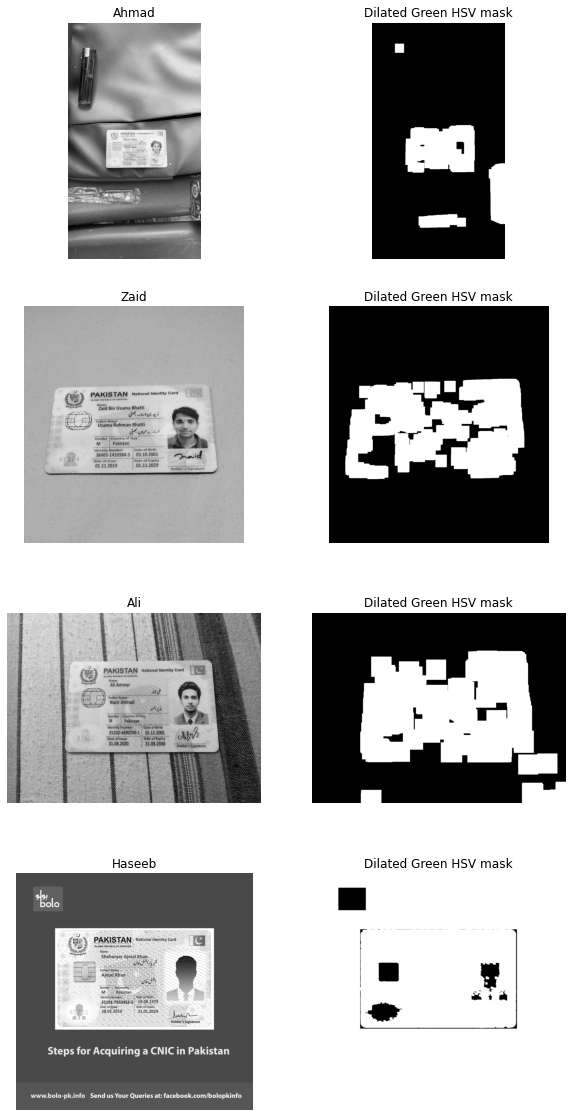

In [80]:
fig = plt.figure(figsize=(10, 20))
# setting values to rows and column variables
rows = 4
columns = 2
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(img1,'gray')
plt.axis('off')
plt.title("Ahmad")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(dil_greens[0],'gray')
plt.axis('off')
plt.title("Dilated Green HSV mask")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(img2,'gray')
plt.axis('off')
plt.title("Zaid")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(dil_greens[1],'gray')
plt.axis('off')
plt.title("Dilated Green HSV mask")

# Adds a subplot at the 5th position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(img3,'gray')
plt.axis('off')
plt.title("Ali")
  
# Adds a subplot at the 6th position
fig.add_subplot(rows, columns, 6)
  
# showing image
plt.imshow(dil_greens[2],'gray')
plt.axis('off')
plt.title("Dilated Green HSV mask")

# Adds a subplot at the 7th position
fig.add_subplot(rows, columns, 7)
  
# showing image
plt.imshow(img4,'gray')
plt.axis('off')
plt.title("Haseeb")
  
# Adds a subplot at the 8th position
fig.add_subplot(rows, columns, 8)
  
# showing image
plt.imshow(dil_greens[3],'gray')
plt.axis('off')
plt.title("Dilated Green HSV mask")

In [81]:
#Filtering the object from dilated green HSV mask with the greatest area
max_areas = []
for dil in dil_greens:
    analysis = cv2.connectedComponentsWithStats(dil,8,cv2.CV_32S)
    (totalLabels, label_ids, values, centroid) = analysis
    count = 0

    # Initialize a new image to store all the output components

    outputi = np.zeros(dil.shape, dtype="uint8")
    area = [] 
    labelids = []

    # Loop through each component
    for i in range(1, totalLabels):   
      # Area of the component
      area.append(values[i, cv2.CC_STAT_AREA])
      labelids.append(i)

    maxarea = max(area)
    maxindex = area.index(maxarea)
    maxlabel = labelids[maxindex]

    componentMask = (label_ids == maxlabel).astype("uint8") * 255
    outputi = cv2.bitwise_or(outputi, componentMask)
    max_areas.append(outputi)

Text(0.5, 1.0, 'Biggest CC in Green HSV mask')

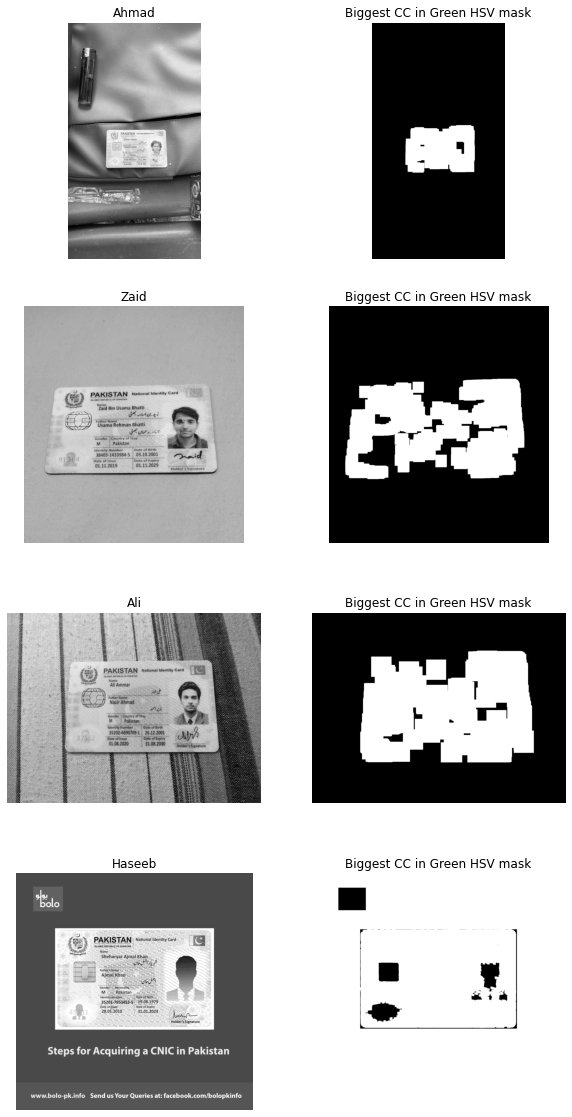

In [82]:
fig = plt.figure(figsize=(10, 20))
# setting values to rows and column variables
rows = 4
columns = 2
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(img1,'gray')
plt.axis('off')
plt.title("Ahmad")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(max_areas[0],'gray')
plt.axis('off')
plt.title("Biggest CC in Green HSV mask")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(img2,'gray')
plt.axis('off')
plt.title("Zaid")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(max_areas[1],'gray')
plt.axis('off')
plt.title("Biggest CC in Green HSV mask")

# Adds a subplot at the 5th position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(img3,'gray')
plt.axis('off')
plt.title("Ali")
  
# Adds a subplot at the 6th position
fig.add_subplot(rows, columns, 6)
  
# showing image
plt.imshow(max_areas[2],'gray')
plt.axis('off')
plt.title("Biggest CC in Green HSV mask")

# Adds a subplot at the 7th position
fig.add_subplot(rows, columns, 7)
  
# showing image
plt.imshow(img4,'gray')
plt.axis('off')
plt.title("Haseeb")
  
# Adds a subplot at the 8th position
fig.add_subplot(rows, columns, 8)
  
# showing image
plt.imshow(max_areas[3],'gray')
plt.axis('off')
plt.title("Biggest CC in Green HSV mask")

In [83]:
#finding edges after dilation and erosion
kernel_de = np.ones((3, 3), np.uint8)
kernel = np.ones((5, 5), np.uint8)

eroded_img = []
for i in adp_th_bl:
    img_dilation = cv2.dilate(i, kernel_de, iterations=1)
    eroded_img.append(cv2.erode(img_dilation, kernel_de, iterations=1))

In [84]:
edge_canny = []
for i in eroded_img:
    canny = cv2.Canny(i, 0, 255)
    canny = cv2.dilate(canny, None, iterations=1)
    canny = cv2.morphologyEx(canny, cv2.MORPH_CLOSE, kernel)
    edge_canny.append(canny)

Text(0.5, 1.0, 'Canny Edges')

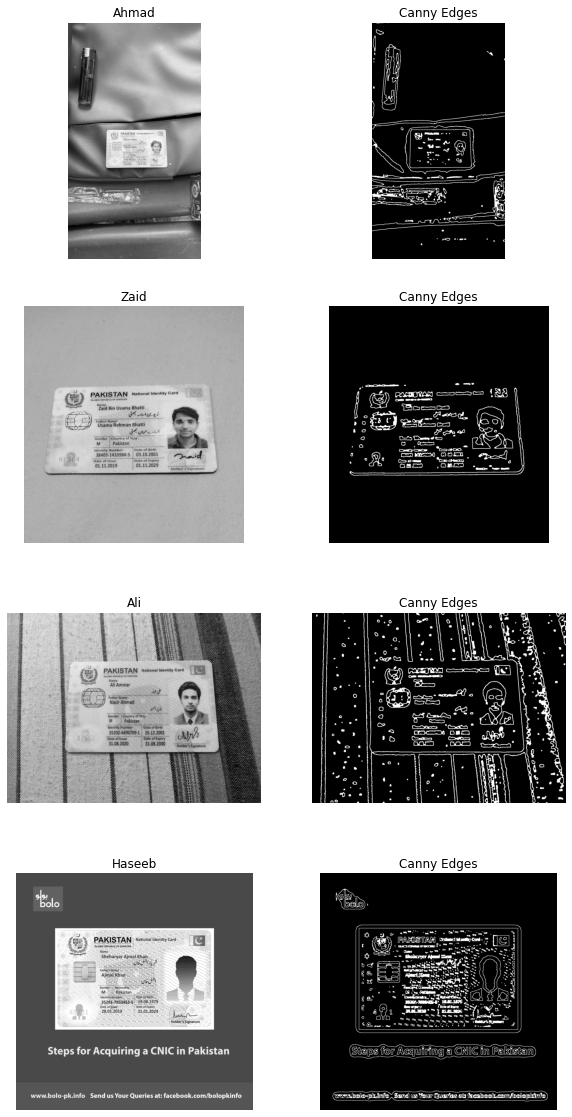

In [85]:
fig = plt.figure(figsize=(10, 20))
# setting values to rows and column variables
rows = 4
columns = 2
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(img[0],'gray')
plt.axis('off')
plt.title("Ahmad")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(edge_canny[0],'gray')
plt.axis('off')
plt.title("Canny Edges")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(img[1],'gray')
plt.axis('off')
plt.title("Zaid")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(edge_canny[1],'gray')
plt.axis('off')
plt.title("Canny Edges")

# Adds a subplot at the 5th position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(img[2],'gray')
plt.axis('off')
plt.title("Ali")
  
# Adds a subplot at the 6th position
fig.add_subplot(rows, columns, 6)
  
# showing image
plt.imshow(edge_canny[2],'gray')
plt.axis('off')
plt.title("Canny Edges")

# Adds a subplot at the 7th position
fig.add_subplot(rows, columns, 7)
  
# showing image
plt.imshow(img[3],'gray')
plt.axis('off')
plt.title("Haseeb")
  
# Adds a subplot at the 8th position
fig.add_subplot(rows, columns, 8)
  
# showing image
plt.imshow(edge_canny[3],'gray')
plt.axis('off')
plt.title("Canny Edges")

In [86]:
#Filtering the objects from canny edges mask with the areas > 500
for can in edge_canny:
    analysis = cv2.connectedComponentsWithStats(can,8,cv2.CV_32S)
    (totalLabels, label_ids, values, centroid) = analysis
    count = 0
    # Initialize a new image to store
    # all the output components
    output = np.zeros(can.shape, dtype="uint8")

    # Loop through each component
    for i in range(1, totalLabels):
        # Area of the component
        area = values[i, cv2.CC_STAT_AREA]

        if (area > 500):
            componentMask = (label_ids == i).astype("uint8") * 255
            output = cv2.bitwise_or(output, componentMask)
    edge_canny[edge_canny.index(can)] = output

C:\Users\Game Boy\AppData\Local\Temp\ipykernel_11500\2716047278.py:18: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  edge_canny[edge_canny.index(can)] = output


Text(0.5, 1.0, 'Filtered Canny Edges')

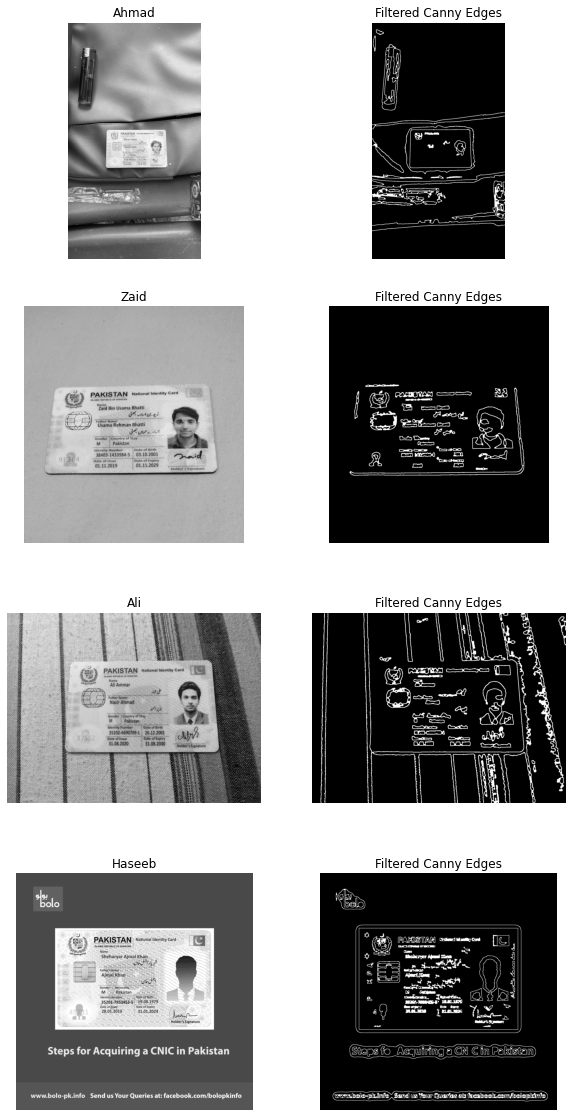

In [87]:
fig = plt.figure(figsize=(10, 20))
# setting values to rows and column variables
rows = 4
columns = 2
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(img[0],'gray')
plt.axis('off')
plt.title("Ahmad")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(edge_canny[0],'gray')
plt.axis('off')
plt.title("Filtered Canny Edges")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(img[1],'gray')
plt.axis('off')
plt.title("Zaid")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(edge_canny[1],'gray')
plt.axis('off')
plt.title("Filtered Canny Edges")

# Adds a subplot at the 5th position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(img[2],'gray')
plt.axis('off')
plt.title("Ali")
  
# Adds a subplot at the 6th position
fig.add_subplot(rows, columns, 6)
  
# showing image
plt.imshow(edge_canny[2],'gray')
plt.axis('off')
plt.title("Filtered Canny Edges")

# Adds a subplot at the 7th position
fig.add_subplot(rows, columns, 7)
  
# showing image
plt.imshow(img[3],'gray')
plt.axis('off')
plt.title("Haseeb")
  
# Adds a subplot at the 8th position
fig.add_subplot(rows, columns, 8)
  
# showing image
plt.imshow(edge_canny[3],'gray')
plt.axis('off')
plt.title("Filtered Canny Edges")

In [88]:
intersection = []
for can in edge_canny:
    diloutput = cv2.dilate(can, np.ones((3,3),np.uint8), iterations=10)
    new_img = cv2.bitwise_and(diloutput,diloutput , mask=max_areas[edge_canny.index(can)])
    intersection.append(new_img)

C:\Users\Game Boy\AppData\Local\Temp\ipykernel_11500\2352284851.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  new_img = cv2.bitwise_and(diloutput,diloutput , mask=max_areas[edge_canny.index(can)])


Text(0.5, 1.0, 'Intersection of Filtered Canny Edges and HSV mask')

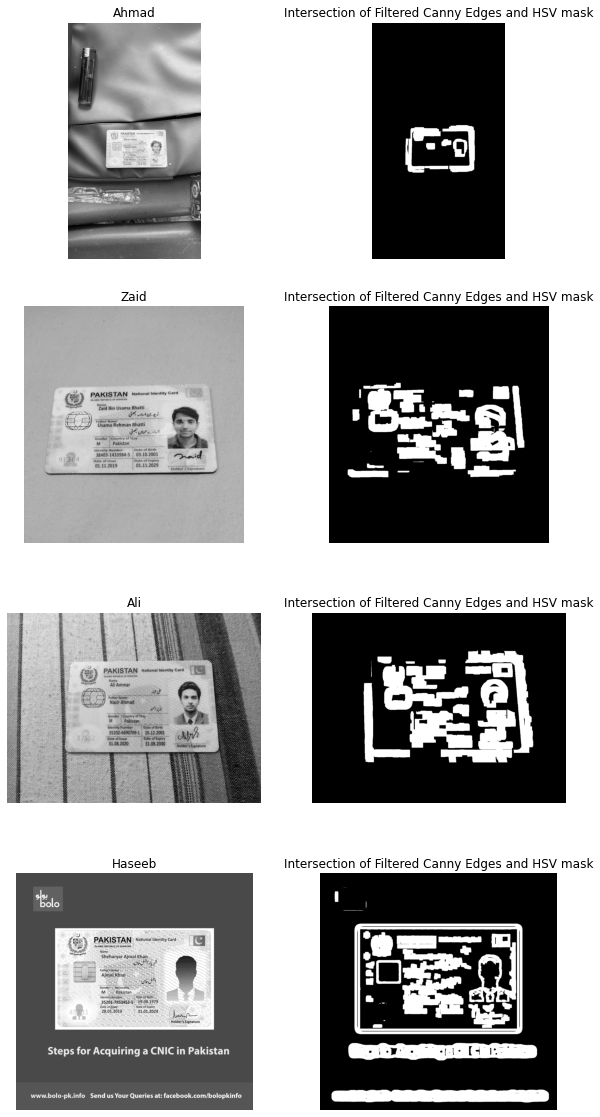

In [89]:
fig = plt.figure(figsize=(10, 20))
# setting values to rows and column variables
rows = 4
columns = 2
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(img[0],'gray')
plt.axis('off')
plt.title("Ahmad")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(intersection[0],'gray')
plt.axis('off')
plt.title("Intersection of Filtered Canny Edges and HSV mask")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(img[1],'gray')
plt.axis('off')
plt.title("Zaid")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(intersection[1],'gray')
plt.axis('off')
plt.title("Intersection of Filtered Canny Edges and HSV mask")

# Adds a subplot at the 5th position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(img[2],'gray')
plt.axis('off')
plt.title("Ali")
  
# Adds a subplot at the 6th position
fig.add_subplot(rows, columns, 6)
  
# showing image
plt.imshow(intersection[2],'gray')
plt.axis('off')
plt.title("Intersection of Filtered Canny Edges and HSV mask")

# Adds a subplot at the 7th position
fig.add_subplot(rows, columns, 7)
  
# showing image
plt.imshow(img[3],'gray')
plt.axis('off')
plt.title("Haseeb")
  
# Adds a subplot at the 8th position
fig.add_subplot(rows, columns, 8)
  
# showing image
plt.imshow(intersection[3],'gray')
plt.axis('off')
plt.title("Intersection of Filtered Canny Edges and HSV mask")

In [90]:
for i in range(len(intersection)):
    if intersection[i].shape[1] <= 1080:
        intersection[i] = cv2.dilate(intersection[i], None, iterations=15)
    elif intersection[i].shape[1] < 2160 and intersection[i].shape[1] > 1080:
        intersection[i] = cv2.dilate(intersection[i], None, iterations=25)    
    else:
        intersection[i] = cv2.dilate(intersection[i], None, iterations=75)

Text(0.5, 1.0, 'Dilated IntersectionS')

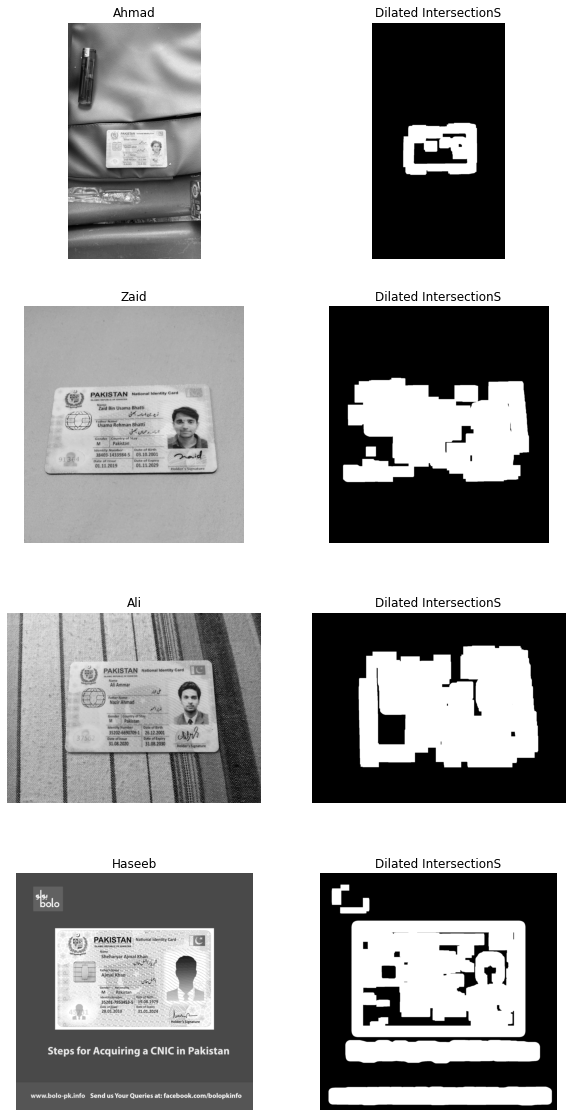

In [91]:
fig = plt.figure(figsize=(10, 20))
# setting values to rows and column variables
rows = 4
columns = 2
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(img[0],'gray')
plt.axis('off')
plt.title("Ahmad")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(intersection[0],'gray')
plt.axis('off')
plt.title("Dilated IntersectionS")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(img[1],'gray')
plt.axis('off')
plt.title("Zaid")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(intersection[1],'gray')
plt.axis('off')
plt.title("Dilated IntersectionS")

# Adds a subplot at the 5th position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(img[2],'gray')
plt.axis('off')
plt.title("Ali")
  
# Adds a subplot at the 6th position
fig.add_subplot(rows, columns, 6)
  
# showing image
plt.imshow(intersection[2],'gray')
plt.axis('off')
plt.title("Dilated IntersectionS")

# Adds a subplot at the 7th position
fig.add_subplot(rows, columns, 7)
  
# showing image
plt.imshow(img[3],'gray')
plt.axis('off')
plt.title("Haseeb")
  
# Adds a subplot at the 8th position
fig.add_subplot(rows, columns, 8)
  
# showing image
plt.imshow(intersection[3],'gray')
plt.axis('off')
plt.title("Dilated IntersectionS")

In [92]:
result = []
for dili in intersection:
    contours, _ = cv2.findContours(dili, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areasi = [cv2.contourArea(c) for c in contours]
    perimetersi = [cv2.arcLength(c, True) for c in contours]
    perimetersi = [round(x, 2) for x in perimetersi]

    # print (len(contours))
    # print(perimetersi)
    # print(contours[areasi.index(max(areasi))])

    def getExtremes(contour):
        leftmost = tuple(contour[contour[:,:,0].argmin()][0])
        rightmost = tuple(contour[contour[:,:,0].argmax()][0])
        topmost = tuple(contour[contour[:,:,1].argmin()][0])
        bottommost = tuple(contour[contour[:,:,1].argmax()][0])
        return leftmost, rightmost, topmost, bottommost


#     print(getExtremes(contours[areasi.index(max(areasi))])) 
    leftmost, rightmost, topmost, bottommost = getExtremes(contours[areasi.index(max(areasi))])   
    leftmost = leftmost[0]
    rightmost = rightmost[0]
    topmost = topmost[1]
    bottommost = bottommost[1]
#     print(leftmost)
#     print(rightmost)
#     print(topmost)
#     print(bottommost)

    for i in range(dili.shape[0]):
        for j in range(dili.shape[1]):
            if i < topmost or i > bottommost or j < leftmost or j > rightmost:
                dili[i,j] = 0
            else:
                dili[i,j] = 255    
    result.append(dili)

Text(0.5, 1.0, 'Final Results')

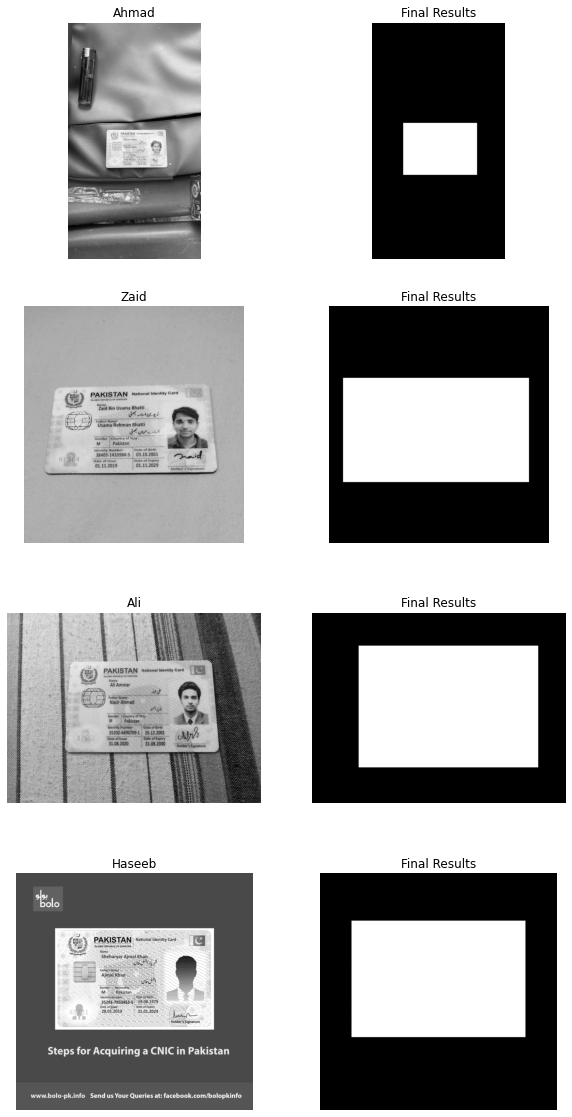

In [93]:
fig = plt.figure(figsize=(10, 20))
# setting values to rows and column variables
rows = 4
columns = 2
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(img[0],'gray')
plt.axis('off')
plt.title("Ahmad")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(result[0],'gray')
plt.axis('off')
plt.title("Final Results")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(img[1],'gray')
plt.axis('off')
plt.title("Zaid")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(result[1],'gray')
plt.axis('off')
plt.title("Final Results")

# Adds a subplot at the 5th position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(img[2],'gray')
plt.axis('off')
plt.title("Ali")
  
# Adds a subplot at the 6th position
fig.add_subplot(rows, columns, 6)
  
# showing image
plt.imshow(result[2],'gray')
plt.axis('off')
plt.title("Final Results")

# Adds a subplot at the 7th position
fig.add_subplot(rows, columns, 7)
  
# showing image
plt.imshow(img[3],'gray')
plt.axis('off')
plt.title("Haseeb")
  
# Adds a subplot at the 8th position
fig.add_subplot(rows, columns, 8)
  
# showing image
plt.imshow(result[3],'gray')
plt.axis('off')
plt.title("Final Results")

Text(0.5, 1.0, 'Segmented CNIC')

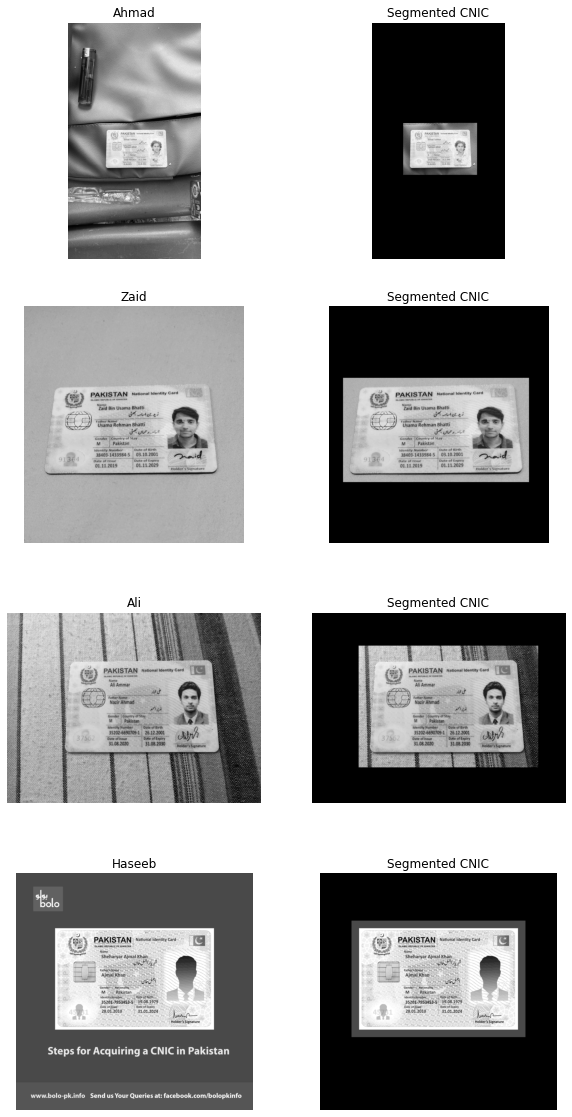

In [94]:
fig = plt.figure(figsize=(10, 20))
# setting values to rows and column variables
rows = 4
columns = 2
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(img[0],'gray')
plt.axis('off')
plt.title("Ahmad")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(cv2.bitwise_and(img[0], img[0], mask=result[0]),'gray')
plt.axis('off')
plt.title("Segmented CNIC")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(img[1],'gray')
plt.axis('off')
plt.title("Zaid")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(cv2.bitwise_and(img[1], img[1], mask=result[1]),'gray')
plt.axis('off')
plt.title("Segmented CNIC")

# Adds a subplot at the 5th position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(img[2],'gray')
plt.axis('off')
plt.title("Ali")
  
# Adds a subplot at the 6th position
fig.add_subplot(rows, columns, 6)
  
# showing image
plt.imshow(cv2.bitwise_and(img[2], img[2], mask=result[2]),'gray')
plt.axis('off')
plt.title("Segmented CNIC")

# Adds a subplot at the 7th position
fig.add_subplot(rows, columns, 7)
  
# showing image
plt.imshow(img[3],'gray')
plt.axis('off')
plt.title("Haseeb")
  
# Adds a subplot at the 8th position
fig.add_subplot(rows, columns, 8)
  
# showing image
plt.imshow(cv2.bitwise_and(img[3], img[3], mask=result[3]),'gray')
plt.axis('off')
plt.title("Segmented CNIC")